In [205]:
import import_ipynb
from Functions import *
import torch.nn.functional as Fun
import torch
from torch import optim
import matplotlib.pyplot as plt
import time
import torch.nn as nn

In [206]:
def Extract(Params):
    return 

## Model

In [207]:
class RModel(nn.Module):
    def __init__(self, T):
        super(RModel, self).__init__()
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.fc1 = nn.Linear(32 * T * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 2 * 2)
        self.T = T

## Objective Function

In [208]:
def Forward(input_tensor, T, model):
    # First Convolutional Layer
    x = model.conv1(input_tensor)
    x = torch.relu(x)
    x = model.pool(x)  # Max pooling over spatial dimensions

    # Second Convolutional Layer
    x = model.conv2(x)
    x = torch.relu(x)
    x = model.pool(x)  # Max pooling over spatial dimensions

    # Adaptive Average Pooling
    x = nn.AdaptiveAvgPool3d((T, 6, 6))(x)

    # Flatten and Fully Connected Layers
    x = x.view(x.size(0), -1)  # Flatten
    x = model.fc1(x)
    x = torch.relu(x)
    x = model.fc2(x)  # Output size of (2, 2)
    
    return x.view(x.size(0), 2, 2)  # Reshape to (2, 2)

## Draw Inconsistencies and noise to frame

In [209]:
def AddOneInc1(F,Op,x,y,xl,yl):
    if isinstance(F, torch.Tensor):
        # Convert to NumPy Array
        F = F.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255
    # Copy of original array
    I = F.astype(np.uint8).copy()

    if Op == 0: #Draw square with changes color ranges
        I[x:xl, y:yl] = change_range_colors(I[x:xl,y:yl], (random.randint(30, 140), random.randint(30, 140), random.randint(30, 140)), (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255)))
    elif Op == 1: #Draw square with random color
        R, G, B = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        I[x:xl,y:yl] = change_range_colors(I[x:xl,y:yl], (R, G, B), (R, G, B))
    elif Op == 2: #Draw line with random color
        Thick = random.randint(1, 10)
        l2 = random.randint(5, I.shape[1]//10)
        I = cv2.line(I, (x, y), (xl,yl), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), Thick)
    elif Op == 3: #Draw black line
        Thick = random.randint(1, 5)
        l2 = random.randint(5, I.shape[1]//10)
        I = cv2.line(I, (x, y), (xl, yl), (0, 0, 0), Thick)  
    elif Op == 4: #Add a square of noise
        I[x:xl,y:yl] = I[x:xl,y:yl] + np.random.random_integers(-10,10,I[x:xl,y:yl].shape)
    elif Op == 5: #Convolution with a random kernel
        kernel = np.random.rand(3,3)
        I[x:xl,y:yl] = cv2.filter2D(I[x:xl,y:yl],-1,kernel)
    elif Op == 6:
        I[x:xl,y:yl] = img_deformation(I[x:xl,y:yl],random.randint(10,50),random.randint(10,100))
    else:# Op == 7:
        I[x:xl,y:yl] = random_point_warp(I[x:xl,y:yl],random.randint(1,5))

    I_tensor = torch.tensor(I,dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)/255.0
    return I_tensor

In [210]:
def read_random_video(directory, N):
    # Get a random video from the directory
    videos = [f for f in os.listdir(directory) if f.endswith(('.mp4', '.avi', '.mov'))]
    if not videos:
        raise ValueError("No video files found in the directory")
    
    video_path = os.path.join(directory, random.choice(videos))
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file {video_path}")
    
    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Ensure N sequential frames and next N frames can be fetched
    if total_frames < 2 * N + 1:
        raise ValueError(f"Video does not have enough frames for N={N} sequential frames.")
    
    # Randomly select a start frame ensuring there are enough remaining frames
    start_frame = random.randint(0, total_frames - (2 * N + 1))
    
    # Read the first N sequential frames
    sequential_frames = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            raise ValueError("Error reading frame from video")
        sequential_frames.append(frame)

    # Read the next single frame
    ret, next_frame = cap.read()
    if not ret:
        raise ValueError("Error reading next frame from video")
    
    # Read the next N sequential frames after the next frame
    next_sequential_frames = []
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            raise ValueError("Error reading next sequential frame from video")
        next_sequential_frames.append(frame)
    
    # Convert lists to numpy arrays and tensors
    sequential_frames = [np.array(frame) for frame in sequential_frames]
    next_frame = np.array(next_frame)
    next_sequential_frames = [np.array(frame) for frame in next_sequential_frames]
    
    cap.release()
    
    return sequential_frames, next_frame, next_sequential_frames

## Training Function

In [211]:
def train(Path, N_Samples=3, state=None, N=1, Epochs=10, Steps=5, LR=1e-3, Size=(320,320)):
    model  = RModel(N)
    if state is not None:
        state = model.load_state_dict(state)
    
    L_Min = 1e20
    Loss = []  # Loss per epoch
    LossAll = []  # Loss for each sample
    
    # Start time for total time estimation
    total_steps = Epochs * N_Samples
    step_count = 0
    start_time = time.time()
    
    for epoch in range(Epochs):
        optimizer = optim.NAdam(model.parameters(), lr=LR)
        total_loss = 0.0
        epoch_start_time = time.time()  # Start time for the current epoch
        
        for sample in range(N_Samples):
            step_count += 1  # Increment step count for time estimation
            optimizer.zero_grad()  # Reset gradients
            
            past, current, future = read_random_video(Path, N) #Numpy Frames
            #Normalize Torch Tensors 
            Past = [Frame2Torch(p, Size, Normalize=True).float() for p in past]
            Current = Frame2Torch(current, Size, Normalize=True).float()
            Future = [Frame2Torch(f, Size, Normalize=True).float() for f in future]
            #Copies of Tensors
            Past_C = [p.clone() for p in Past]
            Current_C = Current.clone()
            Future_C = [f.clone() for f in Future]
            #Coordinates of Inconsistency
            x, y = random.randint(0, 4 * Current.shape[2] // 5), random.randint(0, 4 * Current.shape[3] // 5)
            xl,yl = random.randint(x+1,x+int(Current.shape[2]*0.2)),random.randint(y+1,y+int(Current.shape[3]*0.2))
            
            # Apply noise
            if random.randint(0, 100) < 75:
                steps = random.randint(1, Steps)
                for s in range(steps):
                    Op = random.randint(0, 8)
                    Current_C = AddOneInc1(Current_C,Op,x,y,xl,yl)

                for n in range(len(Past_C)):
                    if random.randint(0, 100) < 30 :
                        steps = random.randint(1, Steps)
                        for s in range(steps):
                            Op = random.randint(0, 8)
                            Past_C[n] = AddOneInc1(Past_C[n],Op,x,y,xl,yl)

                for n in range(len(Future_C)):
                    if random.randint(0, 100) < 30:
                        steps = random.randint(1, Steps)
                        for s in range(steps):
                            Op = random.randint(0, 8)
                            Future_C[n] = AddOneInc1(Future_C[n],Op,x,y,xl,yl)
            else:
                x,y,xl,yl = -10,-10,-10,-10

            In = torch.stack(Past_C+[Current_C]+Future_C,dim=2)
            Target = torch.tensor([[x,y],[x+xl,y+yl]]).unsqueeze(0).float()
            
            # Forward pass
            Pred = Forward(In,N,model)

            # Compute loss
            loss = Fun.mse_loss(Pred,Target)
            # Backpropagation
            loss.backward()
            optimizer.step()

            # Append sample loss
            LossAll.append(loss.item())
            total_loss += loss.item()

            # Sample-wise time estimation
            current_time = time.time()
            elapsed_time = current_time - start_time
            avg_time_per_step = elapsed_time / step_count
            estimated_remaining_time = avg_time_per_step * (total_steps - step_count)
            hrs = int(estimated_remaining_time // 3600)
            mins = int((estimated_remaining_time % 3600) // 60)
            secs = int(estimated_remaining_time % 60)
            
            cv2.imshow('Inconsistent',Frame2Numpy(Current_C,(current.shape[1],current.shape[0]),Denormalize=True))
            #print((Pred[0,0,0].item(),Pred[0,0,1].item()), (Pred[0,1,0].item(),Pred[0,1,1].item()),(x,y),(x+xl,y+yl))
            P_img = Frame2Numpy(Current_C,Denormalize=True)
            P_img = cv2.rectangle(P_img, (Pred[0,0,0],Pred[0,0,1]), (Pred[0,1,0],Pred[0,1,1]), (255,0,0), 1)
            cv2.imshow('Predicted',cv2.resize(P_img,(current.shape[1],current.shape[0])))
            cv2.waitKey(1)

            # Display sample loss and time estimation
            print(f'Epoch[{epoch+1}/{Epochs}] Sample[{sample+1}/{N_Samples}]'
                  f' Loss: {loss.item():.6f} Time Remaining: {hrs:02}:{mins:02}:{secs:02}', end='\r')

        # End of epoch: print the total loss for the epoch
        avg_epoch_loss = total_loss / N_Samples
        Loss.append(avg_epoch_loss)
        print(f'\nEpoch [{epoch+1}/{Epochs}], Average Loss: {avg_epoch_loss:.6f}')

        # Update parameters based on loss
        if Loss[-1] < L_Min:
            state = model.state_dict()
            L_Min = Loss[-1]
            print('-',LR)
        else:
            model.load_state_dict(state)
            print('+',LR)
        
        LR = LR*0.9
    cv2.destroyAllWindows()
    return state,model,Loss, LossAll

## Load Parameters

In [212]:
State = torch.load("RegionModelParams.pth")

## Training

In [213]:
cv2.destroyAllWindows()

In [214]:
State,Model,l,la = train('VDB',N_Samples=20,state=State,N=5,Epochs=10,Steps=10,LR=1e-1,Size=(200,200))

Epoch[1/10] Sample[20/20] Loss: 7724.215332 Time Remaining: 00:02:467
Epoch [1/10], Average Loss: 7845.486890
- 0.1
Epoch[2/10] Sample[20/20] Loss: 12242.997070 Time Remaining: 00:02:32
Epoch [2/10], Average Loss: 9719.548083
+ 0.09000000000000001
Epoch[3/10] Sample[20/20] Loss: 7033.043457 Time Remaining: 00:02:146
Epoch [3/10], Average Loss: 9918.492979
+ 0.08100000000000002


KeyboardInterrupt: 

## Save Parameters

In [200]:
torch.save(State,"RegionModelParams.pth")
State = torch.load("RegionModelParams.pth")

## Plot Epoch's Loss

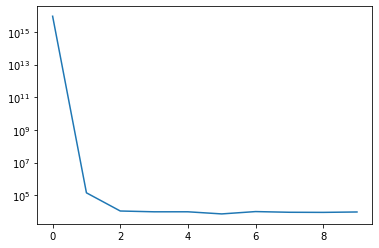

In [201]:
plt.plot(l)
plt.yscale('log')

## Plot Frames Loss

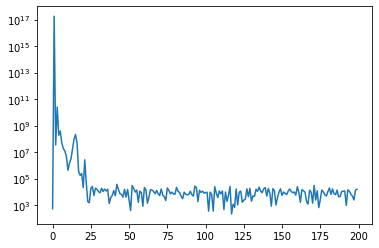

In [202]:
r = 1
plt.plot([sum(la[i:i+r])/r for i in range(0,len(la),r)])
plt.yscale('log')

## Prediction

In [203]:
State = torch.load("RegionModelParams.pth")
cap = open_vid("VDB/L.mp4")
Video = get_frames(cap)

In [204]:
N = 10
for _ in range(15):
    Video[N] = Frame2Numpy(AddOneInc1(Frame2Torch(Video[N],Normalize=True),random.randint(0,8),20,60,80,100),Denormalize=True)

In [ ]:
def GenerateFrames(images, State, frame_size=(320, 320)):
    
    PRED = []
    # Extract parameters from the dictionary
    model = RModel()
     = Extract(Params)

    
    N = len(images)  # Total number of frames
    N_past = len(P)  # Number of past frames
    N_future = len(F)  # Number of future frames
    
    # Convert all frames to torch tensors
    torch_images = [Frame2Torch(img,frame_size,Normalize=True).float() for img in images]
    
    # Iterate through all the frames of the video
    for i in range(N - N_future):
        current = i + N_past
        first = i
        last = current + N_future
        # Select past, current, and future frames
        Past = torch_images[first:current]
        Current = torch_images[current]
        Future = torch_images[current+1:last]
        
        # Apply ObjFun to generate a new frame
        Pred = ObjFun(Current, Past, Future,)
        
        # Convert the predicted frame back to numpy array and rescale to [0, 255]
        Pred_np = Frame2Numpy(Pred,(images[0].shape[1],images[0].shape[0]),Denormalize=True)
        
        PRED.append(Pred_np)
         
    return PRED

In [ ]:
PRED = GenerateFrames(Video[:25],Parameters,(50,50))

In [ ]:
[display_images([Video[b+5],PRED[b]]) for b in range(20)];

In [ ]:
# Define the dimensions for 5 frames
N = 1   # Batch size
C = 3   # Number of channels (RGB)
T = 15   # Number of frames
H = 200 # Height
W = 300 # Width

# Create 5 individual tensors of shape (1, 3, 200, 300)
tensors = [torch.randn(1, 3, H, W) for _ in range(T)]

# Stack the individual tensors to create a single tensor of shape (1, 3, 5, 200, 300)
sample_input = torch.stack(tensors, dim=2)  # Stack along the T dimension

# Check the shape
print(sample_input.shape)  # Should print torch.Size([1, 3, 5, 200, 300])


# Testing the network with a sample input tensor of arbitrary height and width
model = TemporalConsistencyCNN(T=T)  # You can change T to other values if needed
output = model(sample_input)
print(output.shape)  # Should print torch.Size([1, 2, 2])
